In [1]:
import numpy as np
import pandas as pd

from os import path
import pickle
import re

import matplotlib.pyplot as plt
import seaborn as sns

import itertools

import time

from scipy.spatial.distance import pdist, cdist, squareform

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN

from sklearn.metrics import silhouette_score, calinski_harabaz_score

### Import Data

In [2]:
fd = ['..','data','interim']

# Train set
fp = path.join(*fd, 'train.p')
with open(file=fp, mode='rb') as file:
    train = pickle.load(file)

### Cross Tabulation

We will repeat the scaling processes conducted in our previous department clustering analysis to perform similar comparisons:

In [3]:
train['aisle'].nunique()

134

In [4]:
train['user_id'].nunique()

206209

In [5]:
tab = {}

In [6]:
# Regular counts & scaled counts
tab['count'] = pd.crosstab(index=train['user_id'], columns=train['aisle'])
tab['count_norm'] = tab['count'].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)
tab['count_log_norm'] = tab['count'].apply(lambda x: np.log(1+x)).apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)

In [7]:
# Tallied counts & scaled counts (i.e. max 1 per order)
# Remove duplicate records of department per order
temp = train.drop_duplicates(subset=['order_id', 'aisle'])
tab['tally'] = pd.crosstab(index=temp['user_id'], columns=temp['aisle'])
tab['tally_norm'] = tab['tally'].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)
tab['tally_log_norm'] = tab['tally'].apply(lambda x: np.log(1+x)).apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)

In [8]:
# Order aisle proportions
p_temp = train.groupby(['user_id','order_id','aisle'])['product_id'].count().unstack().reset_index(level=1, drop=True)
p_temp = p_temp.div(p_temp.sum(axis=1).values,axis=0)
p_temp = p_temp.fillna(0).groupby('user_id').mean()
p_mean_norm = p_temp.apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)

In [9]:
tab['p_mean_norm'] = p_mean_norm

In [10]:
tab['count'].shape

(206209, 134)

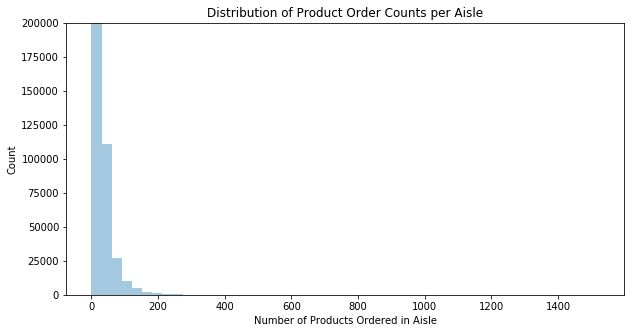

In [11]:
plt.figure(figsize=(10,5))

ax = sns.distplot(tab['count'].unstack(), kde=False)

ax.set_title('Distribution of Product Order Counts per Aisle')
ax.set_ylabel('Count')
ax.set_xlabel('Number of Products Ordered in Aisle')
ax.set_ylim(top=200000)

plt.show()

As one would expect, the distribution of order counts by aisles is largely focused around the the initial 0-200 range.

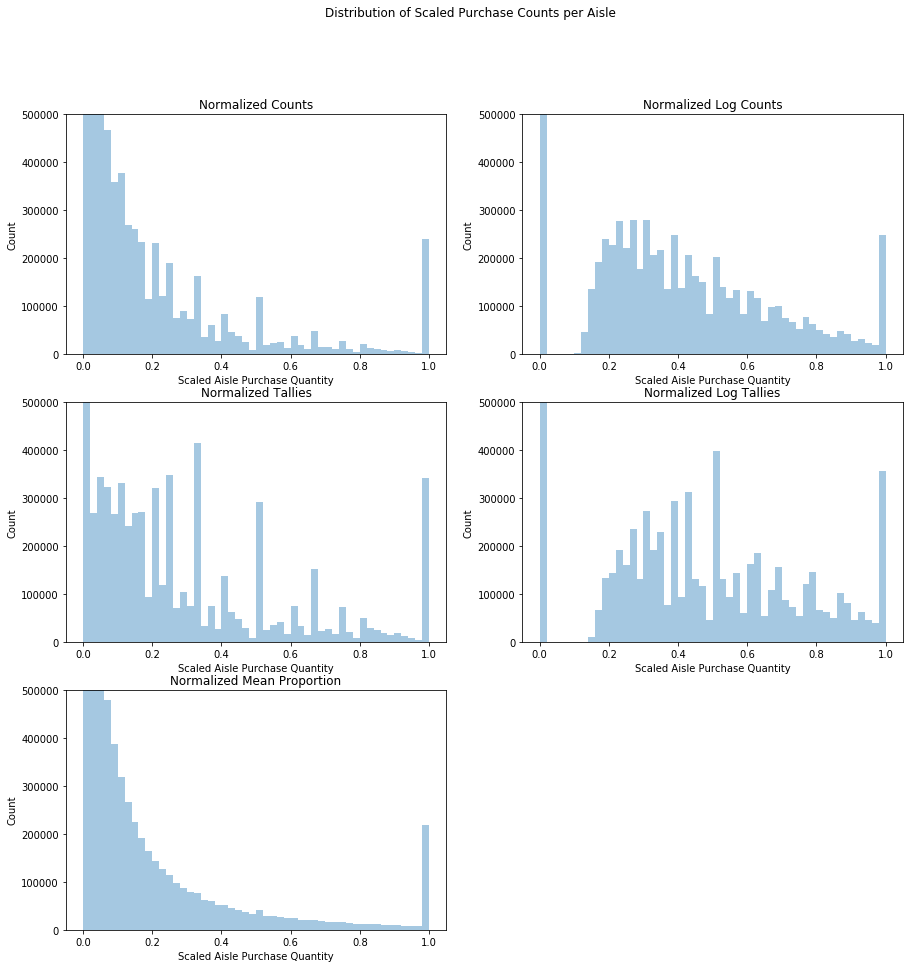

In [12]:
fig, axs = plt.subplots(3,2, figsize=(15,15))

sns.distplot(tab['count_norm'].unstack(), kde=False, ax=axs[0][0])
sns.distplot(tab['count_log_norm'].unstack(), kde=False, ax=axs[0][1])
sns.distplot(tab['tally_norm'].unstack(), kde=False, ax=axs[1][0])
sns.distplot(tab['tally_log_norm'].unstack(), kde=False, ax=axs[1][1])
sns.distplot(tab['p_mean_norm'].unstack(), kde=False, ax=axs[2][0])

for ax in axs.flatten():
    ax.set_xlabel('Scaled Aisle Purchase Quantity')
    ax.set_ylabel('Count')
    ax.set_ylim(top=500000)
    
axs[0][0].set_title('Normalized Counts')
axs[0][1].set_title('Normalized Log Counts')
axs[1][0].set_title('Normalized Tallies')
axs[1][1].set_title('Normalized Log Tallies')
axs[2][0].set_title('Normalized Mean Proportion')
axs[2][1].axis('off')

fig.suptitle('Distribution of Scaled Purchase Counts per Aisle')

plt.show()

The mean proportion scaling, whilst still providing an poisson-like distribution does seem to show the smoothest disribution of scores/values. This could justify use of this feature versus the plain normalized count (or others), but performance of these scalings will ultimately tell.

### Dimensionality Reduction

In [34]:
def plot_pca_var(X, p=0.9):
    
    # Create & fit PCA object
    pca = PCA()
    pca.fit(X)
    
    # Create figure
    plt.figure(figsize=(10,5))
    
    # Get the explained variance and cumulative sum
    n = len(pca.explained_variance_ratio_)
    exp_var = pca.explained_variance_ratio_
    exp_var_cumsum = np.cumsum(exp_var)
    
    # Plot bars for explained variance of each component
    plt.bar(np.arange(1, n+1, 1), exp_var, align='center', label='Explained Variance Ratio')
    # Plot steps for cumulative explained variance
    plt.step(np.arange(1, n+1, 1), exp_var_cumsum, where='mid', label='Cumulative Explained Variance Ratio')
    
    # n_components at which minimum cumalative variance explained is satisfied
    x = next(i for i, n in enumerate(exp_var_cumsum) if n >= p) + 1
    # Markings at the specified desired percentage variance explained
    plt.hlines(p, 0, n, label='{}% Explained Variance Ratio'.format(p*100), lw=1, color='r', linestyle='dashed')
    plt.plot([x, x], [0, p], linestyle='--',color='k', markeredgewidth=3, ms=8, lw=1)
    plt.plot([x], [p], marker='x', color='k', markeredgewidth=2, ms=8, lw=.5)
    plt.annotate(x, (x+.5, p-0.05))
    
    # Generic plot labels
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlim(0, n)
    plt.title('Principal Component Analysis')
        
    # return figure
    return plt.gcf()

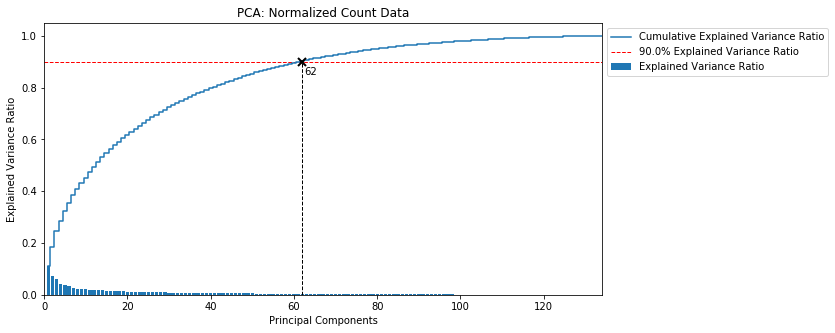

In [35]:
fig = plot_pca_var(tab['count_norm'].values, 0.90)
plt.title('PCA: Normalized Count Data')
plt.show()

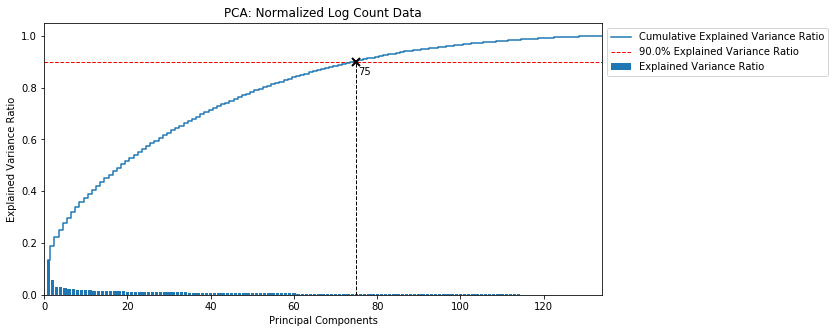

In [36]:
fig = plot_pca_var(tab['count_log_norm'].values, 0.90)
plt.title('PCA: Normalized Log Count Data')
plt.show()

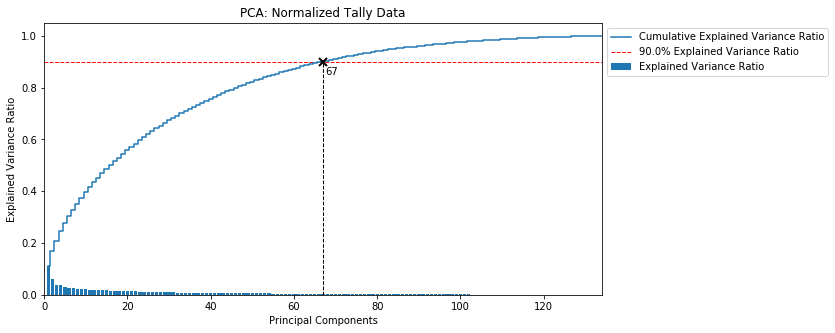

In [37]:
fig = plot_pca_var(tab['tally_norm'].values, 0.90)
plt.title('PCA: Normalized Tally Data')
plt.show()

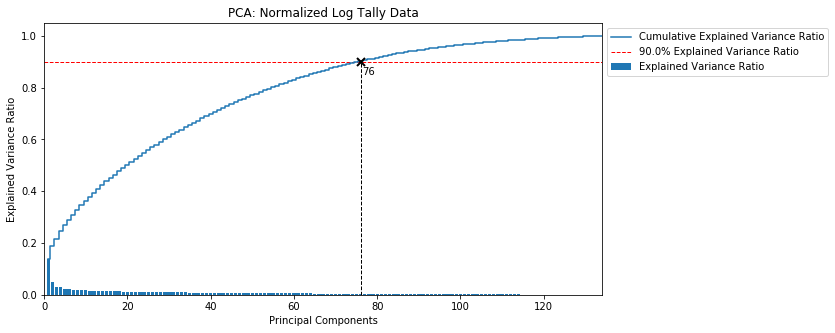

In [38]:
fig = plot_pca_var(tab['tally_log_norm'].values, 0.90)
plt.title('PCA: Normalized Log Tally Data')
plt.show()

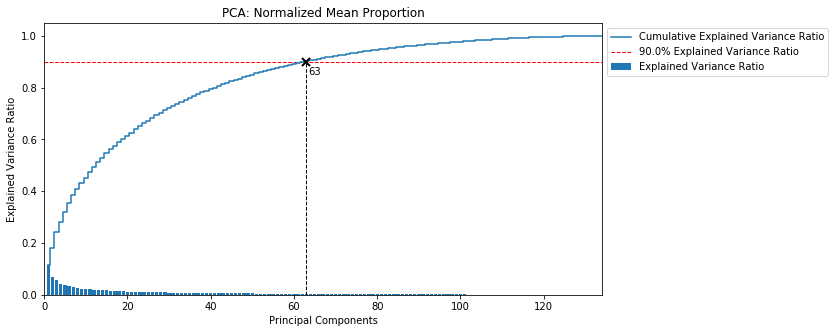

In [39]:
fig = plot_pca_var(tab['p_mean_norm'].values, 0.90)
plt.title('PCA: Normalized Mean Proportion')
plt.show()

All features have the potential for signficant dimensionality reduction via PCA - on the magnitude of 40-50% of components being eliminated whilst still maintaining 90% of variance. We will keep track of these cutoffs for future use:

In [11]:
n_pca = {'count_norm': 62,
         'count_log_norm': 75,
         'tally_norm': 67,
         'tally_log_norm': 76,
         'p_mean_norm': 63}

### Clustering

As with our department clustering we will focus on the following clustering methods:

1. KMEans
2. DBSCAN

##### KMeans

In [51]:
def kmeans_eval(data, n=5, sil_sample_size=10000, verbose=0, n_init=10, batch=False, batch_size=100, n_jobs=1):
    # Create new df to store results
    df = pd.DataFrame(columns=['model', 'inertia','silhouette', 'calinski'])
    df.index.name = 'k'
    # Copy data to avoid changing original
    X = data.copy()
    
    # Number of samplings to run silhouette scoring
    n_samples=5
    # Fix silhouette sample size if larger than size of data
    if sil_sample_size > data.shape[0]:
        sil_sample_size = None
        n_samples = 1
    
    # Loop through each value of k, fit KMeans, and evaluate
    for k in range(2,n+1):
        if verbose > 0:
            print('Processing k = {} ({}/{})'.format(k, k-1,n-1), end='\r')
        # New temp dictionary for results
        km = {}
        # KMeans model
        if batch:
            km['model'] = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init=n_init)
        else:
            km['model'] = KMeans(n_clusters=k, n_init=n_init, n_jobs=n_jobs)
        km['model'].fit(X)
        # Scoring
        km['inertia'] = km['model'].inertia_
        km['silhouette'] = np.mean([silhouette_score(data, km['model'].labels_, sample_size=sil_sample_size) for i in range(n_samples)])
        km['calinski'] = calinski_harabaz_score(data, km['model'].labels_)
        
        # Add new evaluation to dataframe
        df.loc[k] = km
    
    if verbose > 0:
        print('Complete', ' '*50)
    
    return df

We will explore the range of 2-20 clusters for each of our scaled features/tabulations for performance evaluation:

In [44]:
kmeans_results = {}
for d in ['count_norm', 'count_log_norm', 'tally_norm', 'tally_log_norm', 'p_mean_norm']:
    print(d, ':')
    pca = PCA(n_components=n_pca[d])
    X_pca = pca.fit_transform(tab[d].values)
    kmeans_results[d] = kmeans_eval(data=X_pca, n_jobs=4, n=20, verbose=1)

count_norm :
Complete                                                   
count_log_norm :
Complete                                                   
tally_norm :
Complete                                                   
tally_log_norm :
Complete                                                   
p_mean_norm :
Complete                                                   


In [49]:
KMeans?

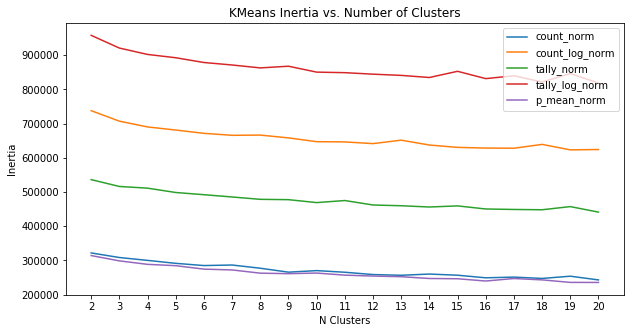

In [45]:
plt.figure(figsize=(10,5))
ax = plt.gca()

for km in kmeans_results:
    ax.plot(kmeans_results[km].index, kmeans_results[km]['inertia'], label=km)

plt.title('KMeans Inertia vs. Number of Clusters')
plt.xlabel('N Clusters')
plt.ylabel('Inertia')
plt.xticks(kmeans_results[km].index,kmeans_results[km].index)
plt.legend()

plt.show()

Based of inertia, we can see that our normalized count and mean proportion values again perform best (lowest inertia). It is hard, however, to discern any particularly favorible number of clusters since the decrease in inertia versus N is relatively small.

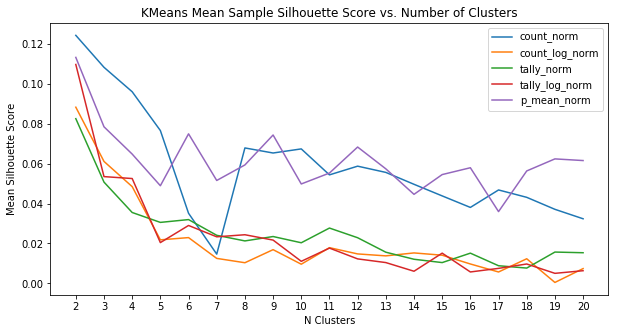

In [46]:
plt.figure(figsize=(10,5))
ax = plt.gca()

for km in kmeans_results:
    ax.plot(kmeans_results[km].index, kmeans_results[km]['silhouette'], label=km)

plt.title('KMeans Mean Sample Silhouette Score vs. Number of Clusters')
plt.xlabel('N Clusters')
plt.ylabel('Mean Silhouette Score')
plt.xticks(kmeans_results[km].index,kmeans_results[km].index)
plt.legend()

plt.show()

As for silhouette scores, we also have those two showing the highest scores. One might be able to roughly infer (with support from the other trends) that the 5 cluster mark is where we see the elbow in the silhouette plots, but we see quite a bit of volatility in the 6-7 cluster range at least for the mean porportion data. Past the 6-7 clusters mark, however, silhouette scores seems to remain relatively stable if try to follow the general trend within the noise, albeit with a gradual decrease at higher cluster numbers. Consequently, whilst 5 clusters may provide the cleanest clustering, increasing past this point should still be feasible if more diversity in cluster assignments is desired to allow for more customized recommendation.

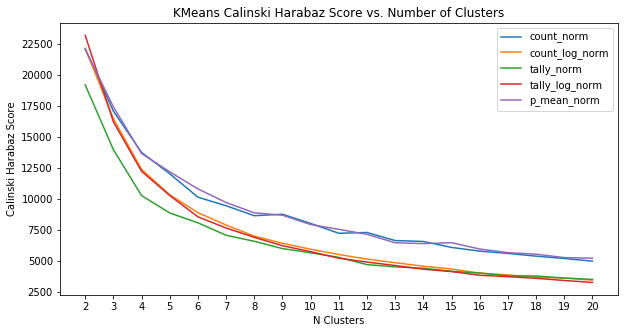

In [24]:
plt.figure(figsize=(10,5))
ax = plt.gca()

for km in kmeans_results:
    ax.plot(kmeans_results[km].index, kmeans_results[km]['calinski'], label=km)

plt.title('KMeans Calinski Harabaz Score vs. Number of Clusters')
plt.xlabel('N Clusters')
plt.ylabel('Calinski Harabaz Score')
plt.xticks(kmeans_results[km].index,kmeans_results[km].index)
plt.legend()

plt.show()

The plot of calinski harabaz scores above again shows the same top performers, but our elbow in the trends leans more toward the 6-7 mark. One could potentially justify using a higher cluster count given these results but the aforementioned volatility in silhouette scores in this range is still of concern.

Taking a look at cluster distributions for our two top performing values/features:

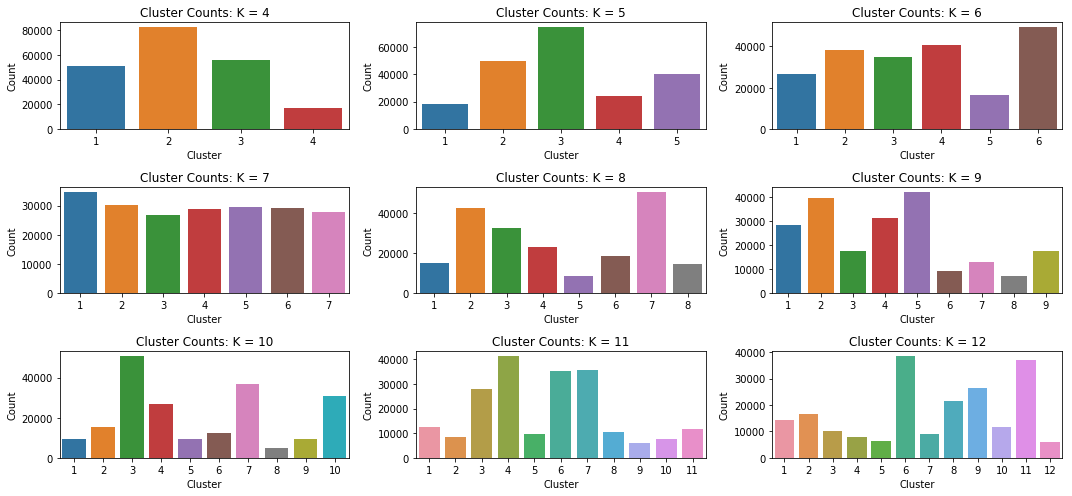

In [53]:
fig, axs = plt.subplots(3,3,figsize=(15,7))

for K, ax in zip(range(4,13),axs.flatten()):
    sns.countplot(kmeans_results['count_norm'].loc[K]['model'].labels_, ax=ax)
    ax.set_title('Cluster Counts: K = {}'.format(K))
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
    ax.set_xticklabels(range(1,K+1))
  
plt.tight_layout()
plt.show()

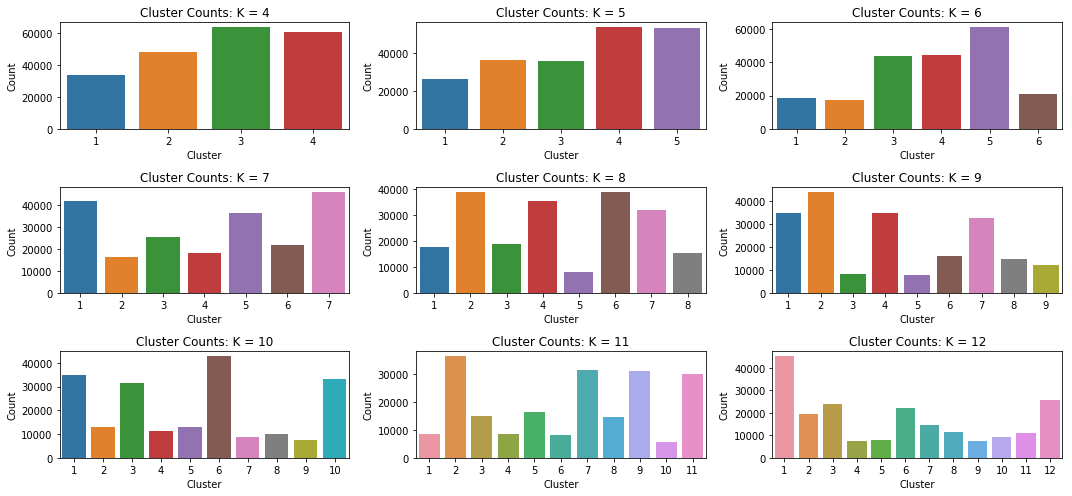

In [52]:
fig, axs = plt.subplots(3,3,figsize=(15,7))

for K, ax in zip(range(4,13),axs.flatten()):
    sns.countplot(kmeans_results['p_mean_norm'].loc[K]['model'].labels_, ax=ax)
    ax.set_title('Cluster Counts: K = {}'.format(K))
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
    ax.set_xticklabels(range(1,K+1))
 
plt.tight_layout()
plt.show()

We can see that the 6 and 7 cluster results for the normalized counts produce very uniform distributions of data across clusters. This is very likely the cause of the low silhouette scores in this region. Past the point of 8 clusters, while we naturally spreading more data between our increase clusters it is not having much of an impact on the larger cluster sizes which continue to hover in the 40k size range. Proceeding with higher cluster counts is unlikely to produce much benefit since we are simply cutting down our smaller clusters.

We will take a look at the 5 cluster model on the combinations of the first 5 principal components to see what kind of separation, if any, is captured via our clustering. Note that 5 clusters has been chosen more for as a visual limit versus higher clusterings which may become difficult to distinguish in these views:

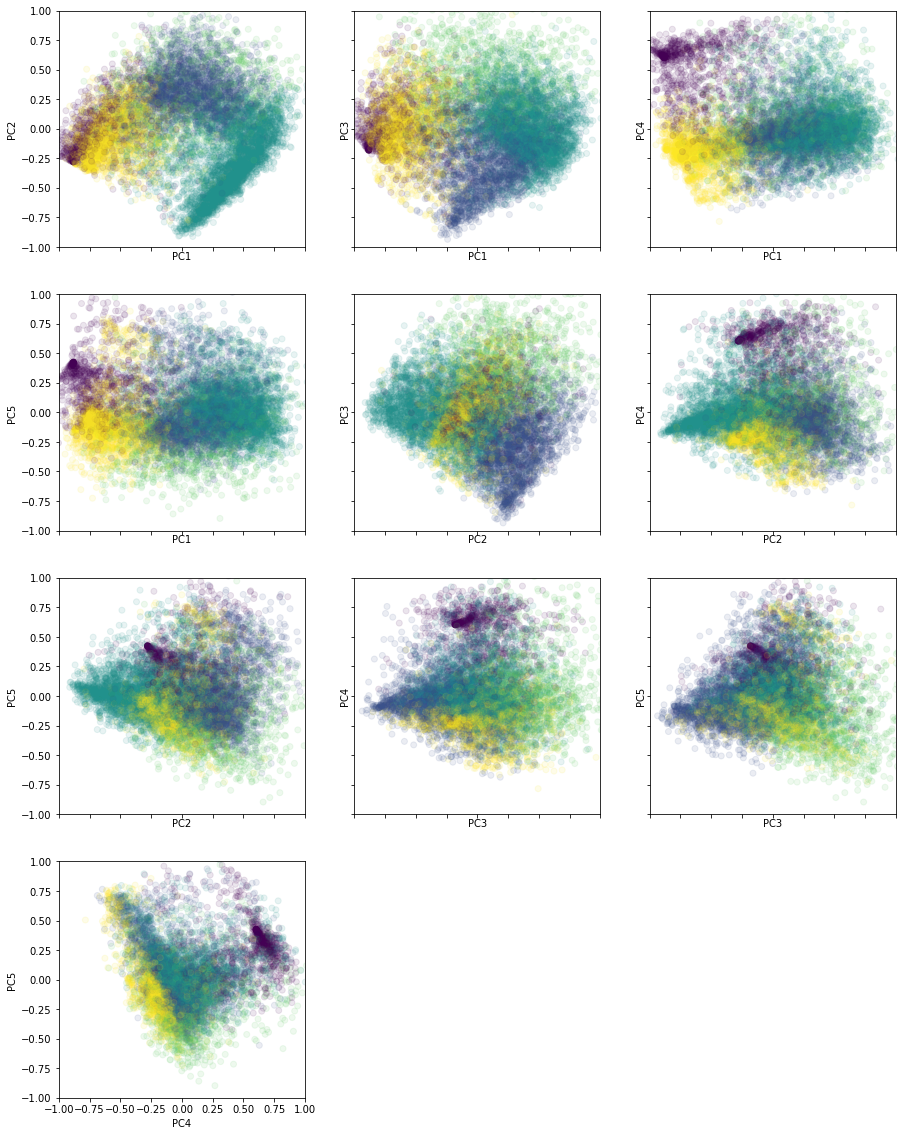

In [76]:
K=5
n_components = 5
combo_list = list(itertools.combinations(np.arange(n_components),2))
n_cols = 3
n_rows = len(combo_list)//n_cols + int(len(combo_list)%n_cols > 0)

fig, axs = plt.subplots(n_rows,n_cols,figsize=(5*n_cols,5*n_rows),sharex=True,sharey=True)

X = PCA(n_components=75).fit_transform(tab['p_mean_norm'])
sample_idx = np.random.choice(X.shape[0], 10000, replace=False)
X_sample = X[sample_idx, :]

for ax, (pc1, pc2) in zip(axs.flatten(), combo_list):
    ax.scatter(x=X_sample.T[pc1], y=X_sample.T[pc2], c=kmeans_results['count_norm'].loc[K]['model'].labels_[sample_idx], alpha=0.1)
    ax.set_xlabel('PC{}'.format(pc1+1))
    ax.set_ylabel('PC{}'.format(pc2+1))
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)

for ax in axs.flatten()[-(n_cols - len(combo_list)%n_cols):]:
    ax.axis('off')

Whilst the data is still fairly muddled around the center and the barriers between clusters are not clearly defined, we do at least see that our clusters are capturing distinct regions in space.

Looking at the taste profiles of each cluster for our 8 cluster model:

In [65]:
top_30_aisles = train.groupby(['aisle'])['product_id'].count().sort_values(ascending=False).index[:30]

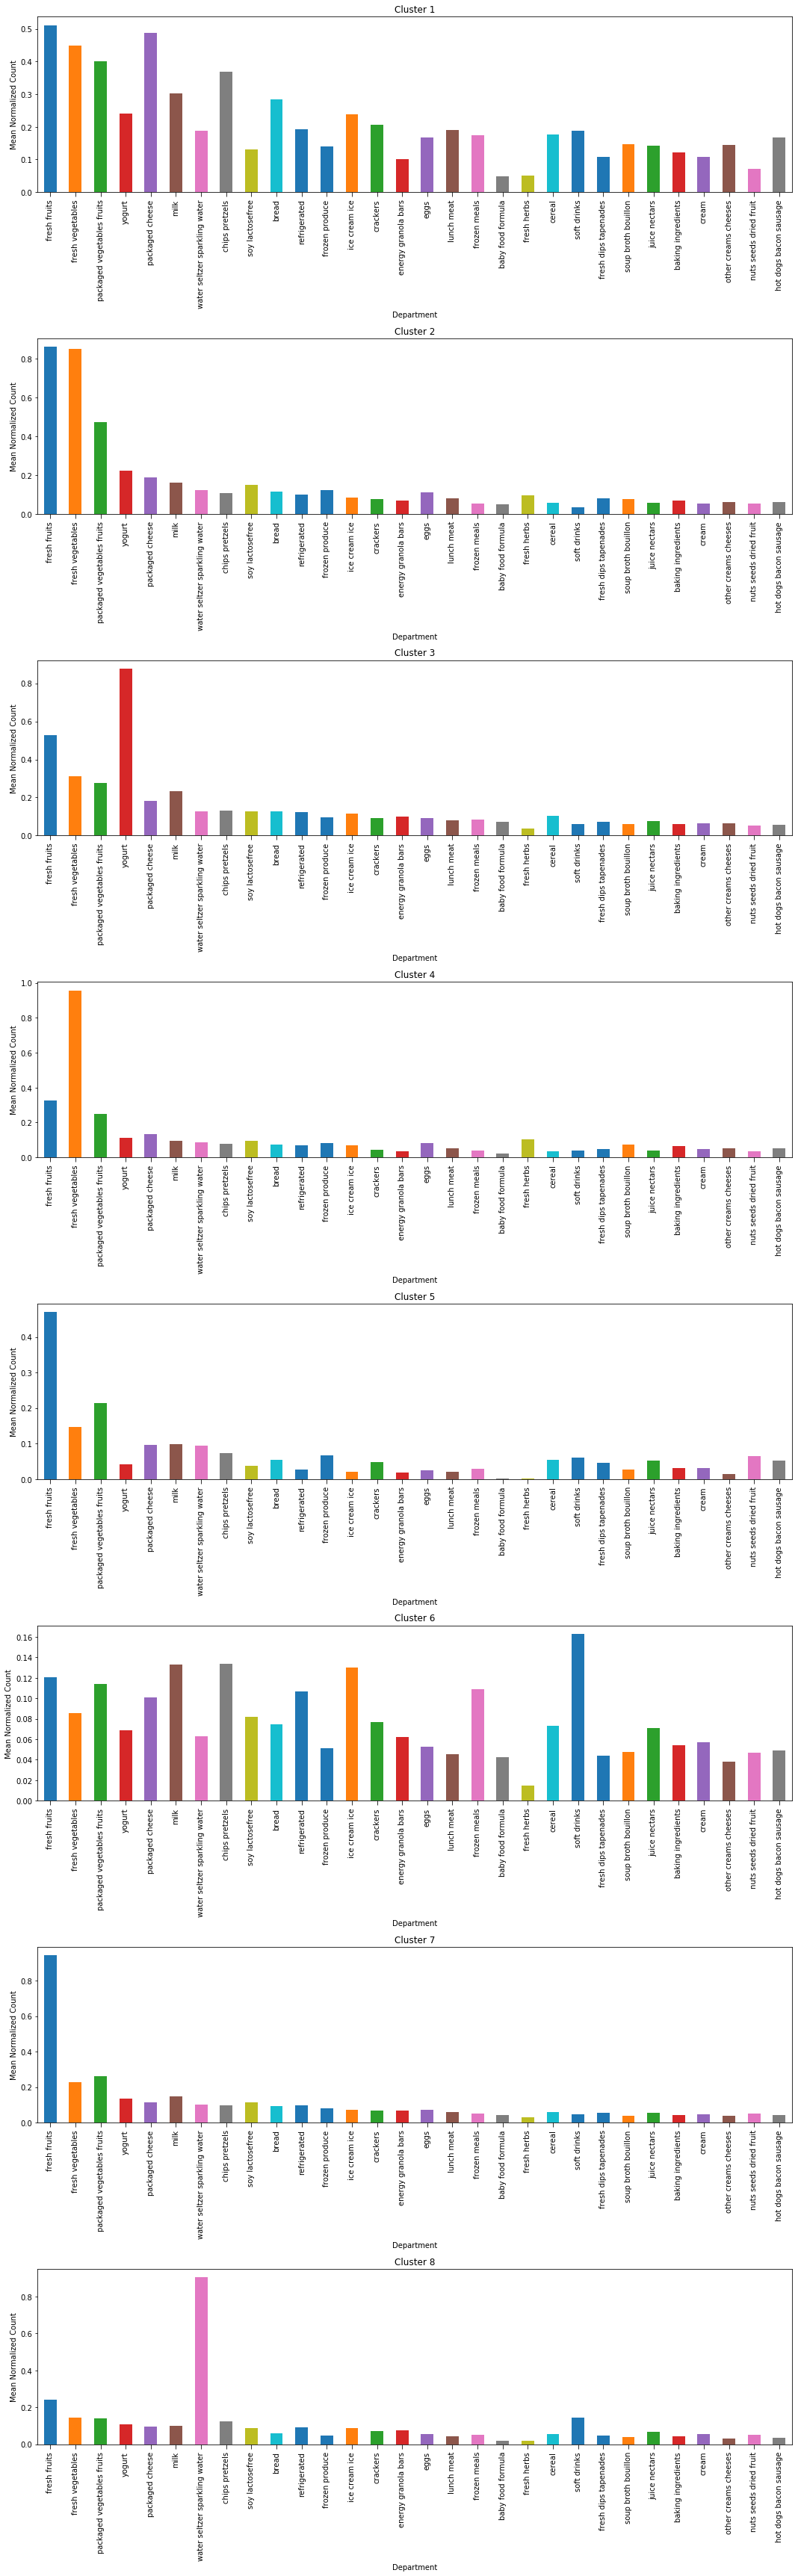

In [69]:
K = 8
clusters = kmeans_results['p_mean_norm']['model'][K].labels_

fig, axs = plt.subplots(K,1,figsize=(15,6*K))
for i, ax in enumerate(axs.flatten()):
    tab['p_mean_norm'].groupby(clusters).mean().loc[i, top_30_aisles].plot.bar(ax=ax)
    ax.set_title('Cluster {}'.format(i+1))
    ax.set_xlabel('Department')
    ax.set_ylabel('Mean Normalized Count')
    ax.xaxis.set_tick_params(size=6)

plt.tight_layout()
plt.show()

We do see some variation between clusters in profile, but most differences seem to be focused around the proportions of the top 3 aisles. It may be more useful to compare all amounts/values to the mean to get a relative higher/lower measure:

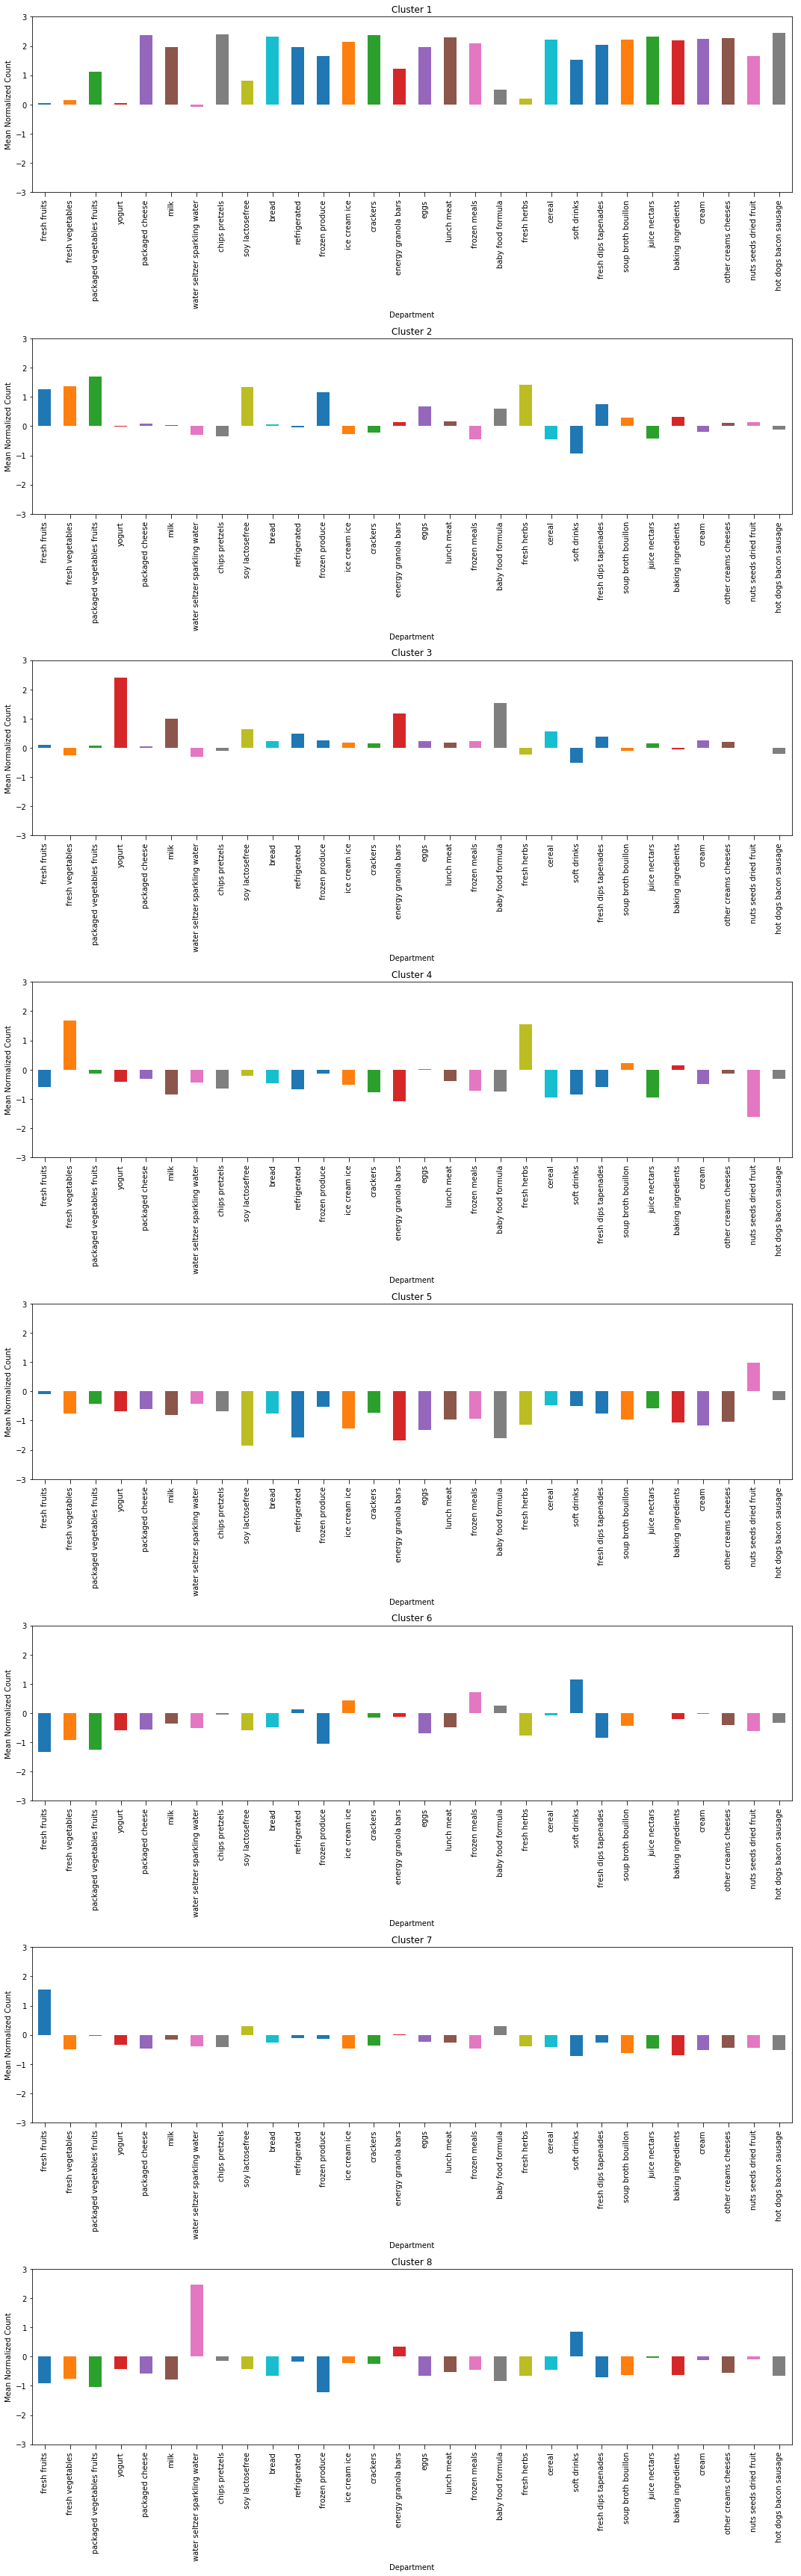

In [90]:
K = 8
clusters = kmeans_results['p_mean_norm']['model'][K].labels_

fig, axs = plt.subplots(K,1,figsize=(15,6*K))
for i, ax in enumerate(axs.flatten()):
    plot_data = (tab['p_mean_norm'].groupby(clusters).mean() - tab['p_mean_norm'].groupby(clusters).mean().mean()) / tab['p_mean_norm'].groupby(clusters).mean().std()
    plot_data.loc[i, top_30_aisles].plot.bar(ax=ax)
    ax.set_title('Cluster {}'.format(i+1))
    ax.set_xlabel('Department')
    ax.set_ylabel('Mean Normalized Count')
    ax.xaxis.set_tick_params(size=6)
    ax.set_ylim(-3,3)

plt.tight_layout()
plt.show()

This view shows us a much greater variety between clusters in terms of taste relative to other clusters, which is a little more reassuring than our original depiction.

Let us see if there are any top purchased products unique to each cluster:

In [91]:
def unique_cluster_products(clusters, top_n=10):
    
    cluster_profile = {}
    for i in np.unique(clusters):
        cluster_orders = train[train['user_id'].isin(tab['p_mean_norm'][clusters==i].index)]
        order_rates = (cluster_orders['product_name'].value_counts()/cluster_orders['order_id'].nunique()).sort_values(ascending=False)
        cluster_profile[i] = order_rates
    
    cluster_unique = {}
    for c, profile in cluster_profile.items():
        other_clusters = set(cluster_profile.keys()).difference(set([c]))
        other_top_products = [item for sublist in [cluster_profile[other_c].index[:top_n] for other_c in other_clusters] for item in sublist]
        other_top_products = np.unique(other_top_products)
        cluster_unique[c] = list(set(profile.index[:top_n]).difference(set(other_top_products)))
    
    return cluster_unique

In [92]:
cluster_unique_10 = unique_cluster_products(clusters, top_n=10)

In [93]:
for c, l in cluster_unique_10.items():
    print('Cluster {}:\n {}\n'.format(c,l))

Cluster 0:
 ['100% Whole Wheat Bread']

Cluster 1:
 []

Cluster 2:
 ['Total 2% with Strawberry Lowfat Greek Strained Yogurt']

Cluster 3:
 ['Organic Garlic', 'Organic Yellow Onion', 'Organic Zucchini']

Cluster 4:
 ['Clementines', 'Rainbow Bell Peppers', 'Baby Cucumbers', 'Raspberries', 'Packaged Grape Tomatoes', 'Hass Avocados', 'Seedless Cucumbers']

Cluster 5:
 ['Organic Half & Half', 'Whole Milk', 'Half & Half']

Cluster 6:
 ['Organic Fuji Apple']

Cluster 7:
 ['Pure Sparkling Water', 'Sparkling Lemon Water', 'Sparkling Mineral Water', 'Sparkling Natural Mineral Water', 'Lime Sparkling Water', 'Spring Water', 'Sparkling Water Grapefruit']



Limiting to the top 10 products constrains the possible variety in unique products, but even so we can identify some unique tastes between clusters. Cluster 3 has a propensity toward certain vegatables, whereas 
cluster 4 purchases considerably more fruit. Cluster 5 is unique with its purchase of dairy - specifically milk/cream products - and clusters 7 is clearly a segment of customers who purchase varieties sparkling water. As for the other clusters, only a few (if any) products stand out, so perhaps an repetition with the top 20 vs. 10 will yield a more diverse list:

In [94]:
cluster_unique_20 = unique_cluster_products(clusters, top_n=20)

In [95]:
for c, l in cluster_unique_20.items():
    print('Cluster {}:\n {}\n'.format(c,l))

Cluster 0:
 ['Blueberries', 'Uncured Genoa Salami']

Cluster 1:
 ['Organic Cucumber', 'Organic Grape Tomatoes']

Cluster 2:
 ['Organic Whole String Cheese', 'Total 2% with Strawberry Lowfat Greek Strained Yogurt', 'Icelandic Style Skyr Blueberry Non-fat Yogurt', 'Total 2% Lowfat Greek Strained Yogurt with Peach', 'Total 2% All Natural Greek Strained Yogurt with Honey', 'Total 2% Lowfat Greek Strained Yogurt With Blueberry']

Cluster 3:
 ['Asparagus', 'Yellow Onions', 'Organic Small Bunch Celery', 'Fresh Cauliflower', 'Michigan Organic Kale', 'Organic Cilantro', 'Organic Red Onion', 'Carrots']

Cluster 4:
 ['Clementines', 'Rainbow Bell Peppers', 'Sweet Kale Salad Mix', 'Baby Cucumbers', 'Raspberries', 'Sinfully Sweet Campari Tomatoes', 'Blackberries', 'Organic Spring Mix', 'Broccoli Florettes', 'Packaged Grape Tomatoes', 'Romaine Hearts', 'Hass Avocados', 'Apples', 'Seedless Cucumbers']

Cluster 5:
 ['Fat Free Milk', 'Fridge Pack Cola', 'Reduced Fat 2% Milk', 'Creamy Peanut Butter', 'Co

In addition to the previous observations, we can see Cluster 2 strongly favors yogurts, and cluster 6 has a tendency toward purchasing apples. These results show some promise as the benefits that may be achieved in segmenting customers via this method in order to provide more customized recommendations.

### DBSCAN

We will start by evaluating our mean proportion data in tandem with DBSCAN clustering. Exploring all varieties of scaling is likely to be too time consuming, so we will focus on those we already established as performing best with KMeans. As for the choice between the normalized count and mean proportion values, the mean proportion simply captures a cleaner spread of data (references our earlier distribution plots).

In [96]:
sample = tab['p_mean_norm'].sample(n=20000)
X_sample = sample.values
X_pca = PCA(n_components=n_pca['p_mean_norm']).fit_transform(X_sample)

In [97]:
pairDistList = pdist(X_pca, metric='euclidean')

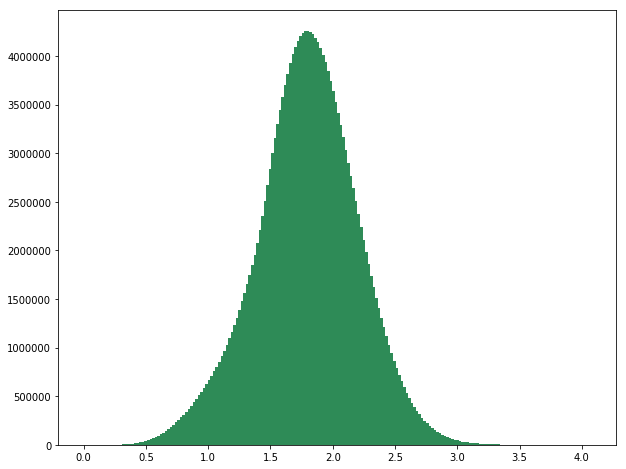

In [98]:
figPairwiseDistances = plt.figure(figsize=(10,8))
plt.hist(pairDistList, bins=200, color='seagreen')
plt.show()

In [23]:
def neighborhoods(data, epsilon):
    n_data = data.shape[0]
    nn = np.zeros(n_data)
    # Compute all - n(n-1)/2 - pairwise distances
    pMat = pdist(data)
    # Compute the (i,j) indexes of pairs that correspond to each elements in pMat
    indexes = np.array([ (i,j) for i in range(n_data) for j in range(i+1, n_data)])
    # Find pairs of data points that are closer than epsilon
    pairs = indexes[np.where(pMat < epsilon)]
    for pair in pairs:
        nn[pair[0]] += 1
        nn[pair[1]] += 1
    return nn

In [29]:
nn = neighborhoods(X_pca, 0.5)

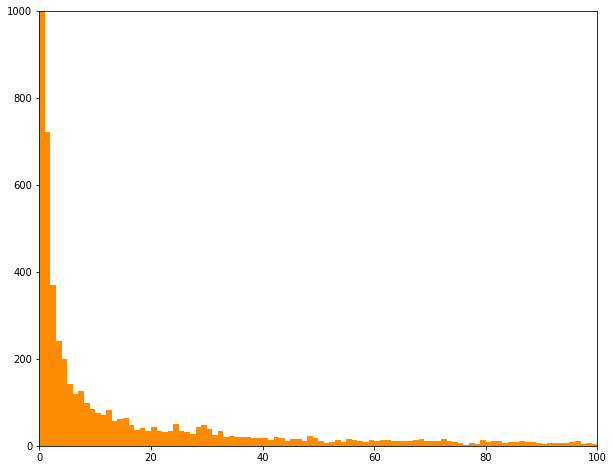

In [30]:
figNeighborhoods = plt.figure(figsize=(10,8))
plt.hist(nn, bins=np.arange(min(nn), max(nn) + 1, 1), color='darkorange')
plt.xlim(0,100)
plt.ylim(top=1000)
plt.show()

These results seem to indicate the same issues we experienced during our department clustering - one large cluster of data which is likely to be challenging to seperate via DBSCAN. We cannot discern much from the plots above, but we will see if we can get a range of values to explore with our grid search via the i-th nearest neighbor method:

In [99]:
def kDist_multi(data, k_range):
    nData = data.shape[0]
    pDistMat = squareform(pdist(data))
    kDistResults = {}
    kDistSorted = [ sorted(pDistMat[i,:]) for i in range(nData) ]
    for k in k_range:
        kDistArray = [ kDistSorted[i][k-1] for i in range(nData)]
        kDistResults[k] = sorted(kDistArray, reverse=True)
    return kDistResults

In [100]:
kDistResults = kDist_multi(X_pca, [4,5,6,10,20])

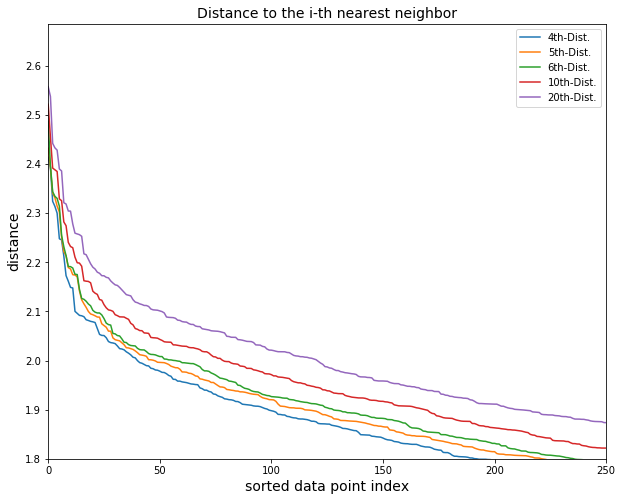

In [101]:
figKDist = plt.figure(figsize=(10,8))

n_data = X_pca.shape[0]

for k in [4,5,6,10,20]:
    plt.plot(range(n_data), kDistResults[k], label='{}th-Dist.'.format(k))

plt.xlim([0,250])
plt.xlabel('sorted data point index', size=14)
plt.ylabel('distance', size=14)
plt.title('Distance to the i-th nearest neighbor', size=14)
plt.legend()
plt.ylim(bottom=1.8)

plt.show()

We can see the elbows in the plots above are in the 2.1-2.2 range. This is a pretty high epsilon, so we will explore a broader spectrum in a rough grid search to start and see where we find the most succesful results:

In [102]:
def cluster_uniformity(cluster_counts):
    d = len(cluster_counts)
    n = sum(cluster_counts)
    norm = [count / n for count in cluster_counts]
    l2 = np.sqrt(sum([x**2 for x in norm]))
    u = 1 - (l2*np.sqrt(d)-1)/(np.sqrt(d)-1)
    return u

In [105]:
def dbscan_gs(data, eps=[0.5,1.0], min_samples=[4,5,6], verbose=0, n_jobs=1):
    f_start_time = time.time()
    n_tests = len(eps)*len(min_samples)
    if verbose > 0:
        print('--- DBSCAN grid search ---')
        print('Total samples = {}'.format(data.shape[0]))
        print('eps values: {}'.format([round(e, 2) for e in eps]))
        print('min_samples values: {}'.format([ms for ms in min_samples]))
        print('Tests = {}'.format(n_tests))
        print('--------------------------')
    # create a dataframe for holding our results
    dbscan_results = pd.DataFrame(columns=['eps', 'min_samples', 'n_clusters', 'cluster_uniformity','cluster_counts','noise_pts'])
    dbscan_results = dbscan_results[['eps', 'min_samples', 'n_clusters', 'cluster_uniformity','cluster_counts','noise_pts']]

    # create values for testing eps & min samples
    params = {'eps': eps,
              'min_samples': min_samples}

    for i, (e, ms) in enumerate(itertools.product(params['eps'],params['min_samples'])):
        start_time = time.time()
        if verbose > 0:
            print('eps: {:.3f}, min_samples: {:.0f}... Fitting DBSCAN {}/{}'.format(e,ms,i+1,n_tests), end='\r')
        db = DBSCAN(eps=e, min_samples=ms, n_jobs=n_jobs).fit(data)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        cluster_counts = np.bincount(labels[labels != -1]).tolist()
        noise_pts = np.sum(labels < 0)
        cluster_uni = cluster_uniformity(cluster_counts) if n_clusters > 1 else np.nan
        if verbose > 0:
            time_delta = time.time() - start_time
            m = time_delta//60
            s = time_delta%60
            time_display = ('{}min '.format(m) if m > 0 else '') + '{:.2f}s'.format(s)
            print('eps: {:.3f}, min_samples: {:.0f}, clusters: {}, uniformity: {:.2f}, noise: {:d}   ({})'.format(e, ms, n_clusters, cluster_uni,noise_pts, time_display)) 

        df_pt = pd.DataFrame({'eps':[e],
                             'min_samples':[ms],
                             'n_clusters':[n_clusters],
                             'cluster_uniformity': cluster_uni,
                             'cluster_counts': [cluster_counts],
                             'noise_pts': [noise_pts]})

        dbscan_results = pd.concat([dbscan_results, df_pt],axis=0)
    
    if verbose > 0:
        time_delta = time.time() - f_start_time
        m = time_delta//60
        s = time_delta%60
        time_display = ('{}min '.format(m) if m > 0 else '') + '{:.2f}s'.format(s)
        print('--------------------------')
        print('Total run time: {}'.format(time_display))
    
    return dbscan_results

In [107]:
dbscan_results = dbscan_gs(X_pca, eps=[0.5,1.0,2.0], min_samples=[4,5,10,20], verbose=1, n_jobs=4)

--- DBSCAN grid search ---
Total samples = 20000
eps values: [0.5, 1.0, 2.0]
min_samples values: [4, 5, 10, 20]
Tests = 12
--------------------------
eps: 0.500, min_samples: 4, clusters: 37, uniformity: 0.14, noise: 15303   (44.11s)
eps: 0.500, min_samples: 5, clusters: 31, uniformity: 0.14, noise: 15397   (44.20s)
eps: 0.500, min_samples: 10, clusters: 19, uniformity: 0.16, noise: 15648   (44.01s)
eps: 0.500, min_samples: 20, clusters: 12, uniformity: 0.32, noise: 16033   (43.94s)
eps: 1.000, min_samples: 4, clusters: 1, uniformity: nan, noise: 4934   (1.0min 46.66s)
eps: 1.000, min_samples: 5, clusters: 1, uniformity: nan, noise: 4953   (1.0min 46.16s)
eps: 1.000, min_samples: 10, clusters: 1, uniformity: nan, noise: 5029   (1.0min 47.77s)
eps: 1.000, min_samples: 20, clusters: 1, uniformity: nan, noise: 5154   (1.0min 46.10s)
eps: 2.000, min_samples: 4, clusters: 1, uniformity: nan, noise: 20   (2.0min 3.95s)
eps: 2.000, min_samples: 5, clusters: 1, uniformity: nan, noise: 20   (2.

In [108]:
dbscan_results

,cluster_counts,cluster_uniformity,eps,min_samples,n_clusters,noise_pts
0,"[15, 4129, 12, 8, 13, 14, 69, 10, 6, 50, 19, 2...",0.144185,0.5,4,37,15303
0,"[15, 4074, 12, 8, 13, 14, 68, 6, 50, 19, 25, 1...",0.139552,0.5,5,31,15397
0,"[3796, 13, 64, 149, 49, 18, 24, 13, 25, 48, 20...",0.164375,0.5,10,19,15648
0,"[3027, 301, 91, 143, 47, 72, 98, 49, 22, 48, 3...",0.324726,0.5,20,12,16033
0,[15066],NaN,1.0,4,1,4934
0,[15047],NaN,1.0,5,1,4953
0,[14971],NaN,1.0,10,1,5029
0,[14846],NaN,1.0,20,1,5154
0,[19980],NaN,2.0,4,1,20
0,[19980],NaN,2.0,5,1,20


Epsilon values (in combination with our min_samples of 5-20) seem to be ineffective past 1.0. We will explore the lower epsilon ranges more in depth to see if any promising results can be obtained:

In [118]:
dbscan_results_2 = dbscan_gs(X_pca, eps=np.arange(0.5,1.0,0.05), min_samples=[3,4,5,6,8,10,12,15,20], verbose=1, n_jobs=4)

--- DBSCAN grid search ---
Total samples = 20000
eps values: [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
min_samples values: [3, 4, 5, 6, 8, 10, 12, 15, 20]
Tests = 90
--------------------------
eps: 0.500, min_samples: 3, clusters: 51, uniformity: 0.15, noise: 15202   (44.37s)
eps: 0.500, min_samples: 4, clusters: 37, uniformity: 0.14, noise: 15303   (44.19s)
eps: 0.500, min_samples: 5, clusters: 31, uniformity: 0.14, noise: 15397   (43.99s)
eps: 0.500, min_samples: 6, clusters: 28, uniformity: 0.18, noise: 15459   (44.54s)
eps: 0.500, min_samples: 8, clusters: 21, uniformity: 0.17, noise: 15572   (44.16s)
eps: 0.500, min_samples: 10, clusters: 19, uniformity: 0.16, noise: 15648   (44.08s)
eps: 0.500, min_samples: 12, clusters: 19, uniformity: 0.27, noise: 15724   (44.17s)
eps: 0.500, min_samples: 15, clusters: 13, uniformity: 0.32, noise: 15906   (44.37s)
eps: 0.500, min_samples: 20, clusters: 12, uniformity: 0.32, noise: 16033   (44.10s)
eps: 0.550, min_samples: 3, clust

In [119]:
dbscan_results_2

,cluster_counts,cluster_uniformity,eps,min_samples,n_clusters,noise_pts
0,"[15, 4170, 12, 8, 13, 14, 69, 14, 6, 10, 6, 50...",0.151672,0.50,3,51,15202
0,"[15, 4129, 12, 8, 13, 14, 69, 10, 6, 50, 19, 2...",0.144185,0.50,4,37,15303
0,"[15, 4074, 12, 8, 13, 14, 68, 6, 50, 19, 25, 1...",0.139552,0.50,5,31,15397
0,"[15, 3869, 12, 13, 68, 170, 6, 50, 19, 25, 10,...",0.180895,0.50,6,28,15459
0,"[3823, 13, 65, 169, 50, 18, 25, 10, 15, 25, 48...",0.173136,0.50,8,21,15572
0,"[3796, 13, 64, 149, 49, 18, 24, 13, 25, 48, 20...",0.164375,0.50,10,19,15648
0,"[3342, 405, 13, 62, 146, 49, 18, 24, 12, 25, 3...",0.274481,0.50,12,19,15724
0,"[3102, 399, 50, 106, 146, 48, 22, 18, 73, 25, ...",0.324059,0.50,15,13,15906
0,"[3027, 301, 91, 143, 47, 72, 98, 49, 22, 48, 3...",0.324726,0.50,20,12,16033
0,"[17, 5380, 14, 8, 19, 88, 63, 18, 7, 13, 7, 25...",0.124129,0.55,3,38,13993


Unfortuantely, as with our department analysis we seem unable to divide up the main cluster without extreme impacts to the number of noise points, and any additional clusters created are on the magnitude of 10-100 items versus the main cluster which remains with 1000s. Based off what we have seen thus far, it is unlikely that further exploration will be able to yield much improvement, so KMeans is likely our best option for clustering.

### Hierarchical Clustering

In [12]:
from sklearn.cluster import AgglomerativeClustering

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [91]:
sample = tab['p_mean_norm'].sample(n=20000)
X_sample = sample.values
X_pca = PCA(n_components=n_pca['p_mean_norm']).fit_transform(X_sample)

In [109]:
def agg_eval(data, n_range=[2,3,4,5], affinity=['euclidean'], linkage=['ward'], verbose=0):
    f_start = time.time()
    df = pd.DataFrame(columns=['model','n_clusters', 'linkage', 'affinity', 'silhouette_score', 'ch_score'])
    
    config_combo = list(itertools.product(linkage, affinity))
    n_combo = len(config_combo)
    for i, (l,a) in enumerate(config_combo):
        combo_start = time.time()
        skip=False
        if verbose > 0:
            print("[{}/{}] {{linkage: '{}', affinity: '{}'}}... ".format(i+1,n_combo,l, a))
        for j,n in enumerate(n_range):
            if l == 'ward' and a != 'euclidean':
                skip = True
                if verbose > 0:
                    print('   Skipped: ward linkage only compatible with euclidean distance')
                break
            if verbose > 0:
                print('   Processing {{n_clusters: {}}} ({}/{})'.format(n, j+1, len(n_range)), end='\r')
            ac = AgglomerativeClustering(affinity=a, linkage=l, n_clusters=n)
            ac.fit(data)
            sil = silhouette_score(data, ac.labels_)
            ch = calinski_harabaz_score(data, ac.labels_)
            new = pd.DataFrame({'model': [ac],
                                'n_clusters': [n],
                                'linkage': [l],
                                'affinity': [a],
                                'silhouette_score': [sil],
                                'ch_score': [ch]})
            df = df.append(new, ignore_index=True)
            
        if verbose > 0 and not skip:
            print('   Complete ({:.0f}s)'.format(time.time()-combo_start), ' '*50)
            
    df = df[['linkage', 'affinity', 'n_clusters', 'silhouette_score', 'ch_score', 'model']]
    return df

In [110]:
ac_results = agg_eval(X_pca, n_range=np.arange(2,13,1), affinity= ['manhattan', 'euclidean', 'cosine'], linkage=['ward', 'complete', 'average'], verbose=1)

[1/9] {linkage: 'ward', affinity: 'manhattan'}... 
   Skipped: ward linkage only compatible with euclidean distance
[2/9] {linkage: 'ward', affinity: 'euclidean'}... 
   Complete (446s)                                                   
[3/9] {linkage: 'ward', affinity: 'cosine'}... 
   Skipped: ward linkage only compatible with euclidean distance
[4/9] {linkage: 'complete', affinity: 'manhattan'}... 
   Complete (456s)                                                   
[5/9] {linkage: 'complete', affinity: 'euclidean'}... 
   Complete (470s)                                                   
[6/9] {linkage: 'complete', affinity: 'cosine'}... 
   Complete (444s)                                                   
[7/9] {linkage: 'average', affinity: 'manhattan'}... 
   Complete (449s)                                                   
[8/9] {linkage: 'average', affinity: 'euclidean'}... 
   Complete (480s)                                                   
[9/9] {linkage: 'average', aff

In [114]:
ac_results.sort_values(by='ch_score', ascending=False)

,linkage,affinity,n_clusters,silhouette_score,ch_score,model
0,ward,euclidean,2,0.031316,1223.848868,"AgglomerativeClustering(affinity='euclidean', ..."
66,average,cosine,2,0.063407,1161.276967,"AgglomerativeClustering(affinity='cosine', com..."
1,ward,euclidean,3,0.030011,912.456203,"AgglomerativeClustering(affinity='euclidean', ..."
34,complete,cosine,3,0.019535,879.923975,"AgglomerativeClustering(affinity='cosine', com..."
22,complete,euclidean,2,0.083228,878.115678,"AgglomerativeClustering(affinity='euclidean', ..."
67,average,cosine,3,0.035239,814.207602,"AgglomerativeClustering(affinity='cosine', com..."
2,ward,euclidean,4,0.030720,760.861011,"AgglomerativeClustering(affinity='euclidean', ..."
68,average,cosine,4,0.032857,729.581432,"AgglomerativeClustering(affinity='cosine', com..."
35,complete,cosine,4,0.021360,677.515103,"AgglomerativeClustering(affinity='cosine', com..."
3,ward,euclidean,5,0.028961,670.848192,"AgglomerativeClustering(affinity='euclidean', ..."


### Additional Options

Whilst we have dismissed DBSCAN and select KMeans as our best clustering method based off our observations thus far, there are some additional options to explore which may yield better results:

- Hierarchal Clustering: This method has yet to be tested. This could potentially circumvent some of the issues with DBSCAN in being unable to 
- Sub-clustering: Running DBSCAN on previously generated clusters (i.e. department or aisle KMeans) may allow for a more manageable approach to each region. A somewhat similar approach was taken with our department analysis where data was compressed into cluster centroid representations, which was not able to provide any improvements, but perhaps we would see different results at the aisle level. One of the likely challenges, however, is that DBSCAN parameters optimized for one cluster may not function well for another due to the varying spread of data in each.